## Colab Setup

In [0]:
# mounting and connecting with drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Setup colab
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# importing train file from gdrive
link = 'https://drive.google.com/open?id=1-EME5voRfDtwq6iS1Zm9VuQnhSTkK6Ee' # Paste the shareable link here

fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train.csv') # file will be stored as train.csv in the colab directory

1-EME5voRfDtwq6iS1Zm9VuQnhSTkK6Ee


In [0]:
# importing labels file from gdrive
link = 'https://drive.google.com/open?id=1i6AIWVIyA4ECPFgoWrwQwASShbuNMmkr' # Paste the shareable link here

fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('labels.json')

1i6AIWVIyA4ECPFgoWrwQwASShbuNMmkr


In [0]:
# importing libraries
import os
import gc
import sys
import math
import json
import glob
import random
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
from tqdm import tqdm

from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold, KFold

import tensorflow as tf

In [0]:
# setting up path directory
TRAIN_IMAGE_DIR = Path('/content/drive/My Drive/Projects/iMaterialist/sample/')
ROOT_DIR = Path('/content/')
DATA_DIR = Path('/content/drive/My Drive/Projects/iMaterialist/')
TEST_DIR = Path('/content/drive/My Drive/Medium_4K train/')

## Data Import

In [0]:
# import train file 
import pandas as pd
train = pd.read_csv('train.csv')
train.head()

,ImageId,EncodedPixels,Height,Width,ClassId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32


In [0]:
# extracting image metadata fom json file 
with open(ROOT_DIR/"labels.json") as f:
    label_descriptions = json.load(f)

label_names = [x['name'] for x in label_descriptions['categories']]

In [0]:
segment_df = train
segment_df['CategoryId'] = segment_df['ClassId'].str.split('_').str[0]

print("Total segments: ", len(segment_df))
segment_df.head()

Total segments:  333415


,ImageId,EncodedPixels,Height,Width,ClassId,CategoryId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,32


In [0]:
# Rows with the same image are grouped together because the subsequent operations perform at an image level
image_df = segment_df.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x))
size_df = segment_df.groupby('ImageId')['Height', 'Width'].mean()
image_df = image_df.join(size_df, on='ImageId')

print("Total images: ", len(image_df))
image_df.head()

Total images:  45625


,EncodedPixels,CategoryId,Height,Width
ImageId,,,,
00000663ed1ff0c4e0132b9b9ac53f6e.jpg,[6068157 7 6073371 20 6078584 34 6083797 48 60...,"[6, 0, 28, 31, 32, 32, 31, 29, 4]",5214,3676
0000fe7c9191fba733c8a69cfaf962b7.jpg,[2201176 1 2203623 3 2206071 5 2208518 8 22109...,"[33, 1]",2448,2448
0002ec21ddb8477e98b2cbb87ea2e269.jpg,[2673735 2 2676734 8 2679734 13 2682733 19 268...,"[33, 10, 23, 23]",3000,1997
0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,[435 132 1002 132 1569 132 2136 132 2703 132 3...,"[10, 33, 15]",567,400
0004467156e47b0eb6de4aa6479cbd15.jpg,[132663 8 133396 25 134130 41 134868 53 135611...,"[10, 33, 31, 31, 15]",750,500


In [0]:
# We will test on 4k images, subsetting data for that

images = os.listdir(TEST_DIR)
uploaded_images = pd.DataFrame(images, columns = ['image_name'])
image_df = image_df[image_df.index.isin(uploaded_images['image_name'])]

## Setting up MASK RCNN

In [0]:
# import matterport Mask-RCNN implementation
!git clone https://www.github.com/matterport/Mask_RCNN.git;
os.chdir('Mask_RCNN')

!rm -rf .git # to prevent an error when the kernel is committed
!rm -rf images assets # to prevent displaying images at the bottom of a kernel

sys.path.append(ROOT_DIR/'Mask_RCNN')
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.81 MiB | 11.33 MiB/s, done.
Resolving deltas: 100% (570/570), done.


Using TensorFlow backend.


In [0]:
# Already have trained weights, we will continue on those weights
pre_trained_weight = '/content/drive/My Drive/Projects/iMaterialist/trained weights/weights_0.08133.h5'

In [0]:
# Set configuration

NUM_CATS = 46  # classification ignoring attributes (only categories)
IMAGE_SIZE = 512 # the image size is set to 512, which is the same as the size of submission masks

class FashionConfig(Config):
    NAME = "fashion"
    NUM_CLASSES = NUM_CATS + 1 # +1 for the background class
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4 
    
    BACKBONE = 'resnet50'
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = "none"
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)

    # STEPS_PER_EPOCH should be the number of instances divided by (GPU_COUNT*IMAGES_PER_GPU), and so should VALIDATION_STEPS;
    STEPS_PER_EPOCH = 50
    VALIDATION_STEPS = 10
    
config = FashionConfig()

In [0]:
# custom function to resize an image, we are resizing image to 512X512; suitable for submission
def resize_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

In [0]:
#  MaskRCNN Class

class FashionDataset(utils.Dataset):

    def __init__(self, df):
        super().__init__(self)
        
        # Add classes
        for i, name in enumerate(label_names):
            self.add_class("fashion", i+1, name)
        
        # Add images 
        for i, row in df.iterrows():
            self.add_image("fashion", 
                           image_id=row.name, 
                           path=str(TRAIN_IMAGE_DIR/row.name), 
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [label_names[int(x)] for x in info['labels']]
    
    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)

## Prediction using our optimized weight

In [0]:
# Prediction, this cell defines InferenceConfig and loads the best trained model.

class InferenceConfig(FashionConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', config=inference_config,model_dir=ROOT_DIR)

model.load_weights(pre_trained_weight, by_name=True)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.








In [0]:
# refine overlapped mask
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

In [0]:
pred_file = image_df.reset_index().iloc[:,:3]

In [0]:
# Convert data to run-length encoding
def to_rle(bits):
    rle = []
    pos = 0
    for bit, group in itertools.groupby(bits):
        group_list = list(group)
        if bit:
            rle.extend([pos, sum(group_list)])
        pos += len(group_list)
    return rle

In [0]:
# Run prediction on test
%%time
test_path = TEST_DIR
sub_list = []
missing_count = 0
for i, row in tqdm(pred_file.iterrows(), total=len(pred_file)):
    image = resize_image(str(test_path/row['ImageId']))
    result = model.detect([image])[0]
    if result['masks'].size > 0:
        masks, _ = refine_masks(result['masks'], result['rois'])
        for m in range(masks.shape[-1]):
            mask = masks[:, :, m].ravel(order='F')
            rle = to_rle(mask)
            label = result['class_ids'][m] - 1
            sub_list.append([row['ImageId'], ' '.join(list(map(str, rle))), label])
    else:
        # The system does not allow missing ids, this is an easy way to fill them 
        sub_list.append([row['ImageId'], '1 1', 23])
        missing_count += 1

100%|██████████| 4103/4103 [1:37:36<00:00,  1.53s/it]

CPU times: user 34min 16s, sys: 9min 41s, total: 43min 57s
Wall time: 1h 37min 36s


In [0]:
# save predicted data in submission file to upload in Kaggle
pred_df = pd.DataFrame(sub_list, columns=pred_file.columns.values)
print("Total image results: ", pred_df['ImageId'].nunique())
print("Missing Images: ", missing_count)

pred_df.head()

Total image results:  4103
Missing Images:  4


,ImageId,EncodedPixels,CategoryId
0,0000fe7c9191fba733c8a69cfaf962b7.jpg,102498 4 103010 5 103522 6 104036 5 104549 5 1...,33
1,0000fe7c9191fba733c8a69cfaf962b7.jpg,173885 26 174395 30 174463 2 174719 11 174906 ...,31
2,0002ec21ddb8477e98b2cbb87ea2e269.jpg,135642 12 136150 18 136662 19 137185 9 137698 ...,23
3,0002ec21ddb8477e98b2cbb87ea2e269.jpg,118208 2 118716 10 119227 12 119737 15 120248 ...,23
4,0002ec21ddb8477e98b2cbb87ea2e269.jpg,102659 25 103166 34 103673 50 104179 70 104686...,10


In [0]:
pred_df.to_csv('pred_df.csv')

In [0]:
# Rows with the same image grouped together
pred_df2 = pred_df.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x))
pred_df2.head()

,EncodedPixels,CategoryId
ImageId,,
0000fe7c9191fba733c8a69cfaf962b7.jpg,[102498 4 103010 5 103522 6 104036 5 104549 5 ...,"[33, 31]"
0002ec21ddb8477e98b2cbb87ea2e269.jpg,[135642 12 136150 18 136662 19 137185 9 137698...,"[23, 23, 10, 33]"
0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,[4544 4 5053 10 5563 13 6073 16 6582 21 7091 2...,"[10, 33, 33, 37]"
000aac3870ea7c59ca0333ffa5327323.jpg,[95481 11 95982 30 96482 47 96989 55 97495 63 ...,"[31, 33, 10, 33]"
000b3a87508b0fa185fbd53ecbe2e4c6.jpg,[141205 6 141715 10 142226 12 142736 15 143246...,"[24, 33, 10, 19, 13, 21, 21]"


In [0]:
image_df.head()

,EncodedPixels,CategoryId,Height,Width
ImageId,,,,
0000fe7c9191fba733c8a69cfaf962b7.jpg,[2201176 1 2203623 3 2206071 5 2208518 8 22109...,"[33, 1]",2448,2448
0002ec21ddb8477e98b2cbb87ea2e269.jpg,[2673735 2 2676734 8 2679734 13 2682733 19 268...,"[33, 10, 23, 23]",3000,1997
0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,[435 132 1002 132 1569 132 2136 132 2703 132 3...,"[10, 33, 15]",567,400
000aac3870ea7c59ca0333ffa5327323.jpg,[8971124 17 8975101 49 8979077 82 8983053 116 ...,"[10, 33, 3, 31, 31, 33]",4000,6000
000b3a87508b0fa185fbd53ecbe2e4c6.jpg,[291578 3 292856 8 294133 13 295410 19 296687 ...,"[10, 33, 24]",1280,852


In [0]:
image_df.shape,pred_df2.shape

((4103, 4), (4103, 2))

In [0]:
combine_df = image_df.reset_index().merge(pred_df2.reset_index(), how='inner', left_on='ImageId', right_on='ImageId').loc[:,['ImageId','CategoryId_x','CategoryId_y']]

In [0]:
combine_df.columns = ['ImageId','Truth','Prediction']
combine_df.head()

,ImageId,Truth,Prediction
0,0000fe7c9191fba733c8a69cfaf962b7.jpg,"[33, 1]","[33, 31]"
1,0002ec21ddb8477e98b2cbb87ea2e269.jpg,"[33, 10, 23, 23]","[23, 23, 10, 33]"
2,0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,"[10, 33, 15]","[10, 33, 33, 37]"
3,000aac3870ea7c59ca0333ffa5327323.jpg,"[10, 33, 3, 31, 31, 33]","[31, 33, 10, 33]"
4,000b3a87508b0fa185fbd53ecbe2e4c6.jpg,"[10, 33, 24]","[24, 33, 10, 19, 13, 21, 21]"


In [0]:
combine_df['Truth'] = combine_df['Truth'].map(lambda x:[int(y) for y in x])

In [0]:
combine_df.head()

,ImageId,Truth,Prediction,correct
0,0000fe7c9191fba733c8a69cfaf962b7.jpg,"[33, 1]","[33, 31]",[33]
1,0002ec21ddb8477e98b2cbb87ea2e269.jpg,"[33, 10, 23, 23]","[23, 23, 10, 33]","[33, 10, 23]"
2,0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,"[10, 33, 15]","[10, 33, 33, 37]","[33, 10]"
3,000aac3870ea7c59ca0333ffa5327323.jpg,"[10, 33, 3, 31, 31, 33]","[31, 33, 10, 33]","[33, 10, 31]"
4,000b3a87508b0fa185fbd53ecbe2e4c6.jpg,"[10, 33, 24]","[24, 33, 10, 19, 13, 21, 21]","[24, 33, 10]"


In [0]:
combine_df['correct']= combine_df['Truth']
combine_df['missed']= combine_df['Truth']
combine_df['extra']= combine_df['Truth']

In [0]:
for i in range(len(combine_df)):
  combine_df.loc[i,'correct'] = (list(set(combine_df.iloc[i,1]).intersection(combine_df.iloc[i,2])))
  combine_df.loc[i,'missed'] = (list(set(combine_df.iloc[i,1]) - set(combine_df.iloc[i,2])))
  combine_df.loc[i,'extra'] = (list(set(combine_df.iloc[i,2]) - set(combine_df.iloc[i,1])))

In [0]:
combine_df.head()

,ImageId,Truth,Prediction,correct,missed,extra
0,0000fe7c9191fba733c8a69cfaf962b7.jpg,"[33, 1]","[33, 31]",[33],[1],[31]
1,0002ec21ddb8477e98b2cbb87ea2e269.jpg,"[33, 10, 23, 23]","[23, 23, 10, 33]","[33, 10, 23]",[],[]
2,0002f5a0ebc162ecfb73e2c91e3b8f62.jpg,"[10, 33, 15]","[10, 33, 33, 37]","[33, 10]",[15],[37]
3,000aac3870ea7c59ca0333ffa5327323.jpg,"[10, 33, 3, 31, 31, 33]","[31, 33, 10, 33]","[33, 10, 31]",[3],[]
4,000b3a87508b0fa185fbd53ecbe2e4c6.jpg,"[10, 33, 24]","[24, 33, 10, 19, 13, 21, 21]","[24, 33, 10]",[],"[21, 19, 13]"


In [0]:
correct_list = []
missed_list = []
extra_list = []

for i in range(len(combine_df)):
  correct_list.extend(combine_df.iloc[i,3])
  missed_list.extend(combine_df.iloc[i,4])
  extra_list.extend(combine_df.iloc[i,5])

In [0]:
label_df = pd.DataFrame(label_names).reset_index()
label_df.columns = ['Id','Labels']
label_df.head()

,Id,Labels
0,0,"shirt, blouse"
1,1,"top, t-shirt, sweatshirt"
2,2,sweater
3,3,cardigan
4,4,jacket


In [0]:
from collections import Counter
correct_df = pd.DataFrame.from_dict(Counter(correct_list), orient='index').reset_index().sort_values(by = 0, ascending = False)\
                        .merge(label_df, left_on = 'index', right_on='Id').loc[:,[0,'Labels']]
correct_df.columns = ['Count Correct','Labels']
correct_df.head(10)

,Count Correct,Labels
0,2566,sleeve
1,2409,neckline
2,2040,shoe
3,1308,dress
4,1037,pants
5,890,"top, t-shirt, sweatshirt"
6,605,pocket
7,565,collar
8,417,jacket
9,366,lapel


In [0]:
missed_df = pd.DataFrame.from_dict(Counter(missed_list), orient='index').reset_index().sort_values(by = 0, ascending = False)\
                        .merge(label_df, left_on = 'index', right_on='Id').loc[:,[0,'Id','Labels']]
missed_df.columns = ['Count Missed','Label Id','Labels']
missed_df.head()

,Count Missed,Label Id,Labels
0,609,32,pocket
1,581,1,"top, t-shirt, sweatshirt"
2,568,33,neckline
3,469,0,"shirt, blouse"
4,411,19,belt


In [0]:
extra_df = pd.DataFrame.from_dict(Counter(extra_list), orient='index').reset_index().sort_values(by = 0, ascending = False)\
                        .merge(label_df, left_on = 'index', right_on='Id').loc[:,[0,'Labels']]
extra_df.columns = ['Count Extra','Labels']
extra_df.head()

,Count Extra,Labels
0,701,sleeve
1,423,"top, t-shirt, sweatshirt"
2,422,pants
3,356,dress
4,315,shoe


In [0]:
error_analysis = missed_df.merge(correct_df, how = 'left', on='Labels').fillna(0)

In [0]:
error_analysis['missed %'] = (error_analysis['Count Missed']*100)/(error_analysis['Count Missed']+error_analysis['Count Correct'])
error_analysis['total labels'] = (error_analysis['Count Missed']+error_analysis['Count Correct'])

In [0]:
error_analysis.sort_values(by = 'total labels', ascending=False).head(15)

,Count Missed,Label Id,Labels,Count Correct,missed %,total labels
2,568,33,neckline,2409.0,19.079610,2977.0
35,65,31,sleeve,2566.0,2.470544,2631.0
31,79,23,shoe,2040.0,3.728174,2119.0
5,334,10,dress,1308.0,20.341048,1642.0
1,581,1,"top, t-shirt, sweatshirt",890.0,39.496941,1471.0
0,609,32,pocket,605.0,50.164745,1214.0
19,125,6,pants,1037.0,10.757315,1162.0
8,295,28,collar,565.0,34.302326,860.0
10,271,4,jacket,417.0,39.389535,688.0
4,411,19,belt,227.0,64.420063,638.0


In [0]:
error_analysis1 = error_analysis[error_analysis['total labels']>200].sort_values(by ='missed %')

In [0]:
error_analysis1.to_csv('error_analysis1.csv')

In [0]:
import pandas as pd
error_analysis1 = pd.read_csv('error_analysis1_sensitivity.csv')

In [0]:
error_analysis1.head()

,Unnamed: 0,Count Missed,Label Id,Labels,Count Correct,missed %,total labels,Sensitivity
0,35,65,31,sleeve,2566,2.470544,2631,97.529456
1,31,79,23,shoe,2040,3.728174,2119,96.271826
2,19,125,6,pants,1037,10.757315,1162,89.242685
3,2,568,33,neckline,2409,19.079610,2977,80.920390
4,5,334,10,dress,1308,20.341048,1642,79.658952


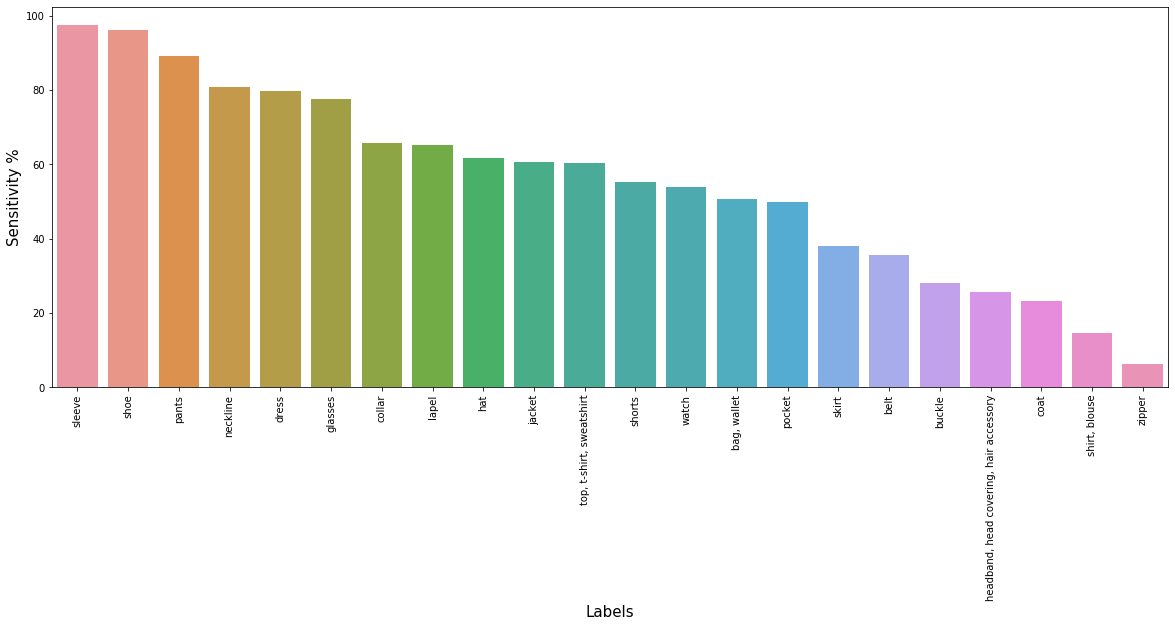

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 7))
sns.barplot(error_analysis1['Labels'],error_analysis1['Sensitivity'])
plt.xlabel("Labels", fontsize=15)
plt.xticks(rotation=90)
plt.ylabel("Sensitivity %", fontsize=15)
plt.show()

In [0]:
# total_missed
pd.DataFrame.from_dict(Counter(missed_list), orient='index').reset_index().sort_values(by = 0, ascending = False)[0].sum()

7714

In [0]:
# total_correct
pd.DataFrame.from_dict(Counter(correct_list), orient='index').reset_index().sort_values(by = 0, ascending = False)[0].sum()

14351

In [0]:
pd.DataFrame.from_dict(Counter(extra_list), orient='index').reset_index().sort_values(by = 0, ascending = False)[0].sum()

4514